# Approach 2: Baseline Training (No FDA)

## Training Only on Algerian Data (101 samples)

**Purpose**: Validate baseline performance using only real Algerian satellite imagery without domain adaptation.

### Key Differences from Approach 1:
- **No FDA-adapted PASTIS data**: Only uses 101 Algerian training samples
- **No hybrid training**: Pure Algerian data training
- **Small dataset challenge**: Tests model capability with limited data

### Data Summary:
- **Training**: 101 Algerian samples (cereal vs non-cereal)
- **Validation**: 92 Algerian samples
- **Input Shape**: (10, 128, 128) - 10 Sentinel-2 bands
- **Challenge**: Very small training set (101 samples)

In [1]:
# =============================================================================
# CELL 1: Imports and Setup
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Check for GPU
def get_device():
    if torch.cuda.is_available():
        try:
            test_tensor = torch.zeros(1).cuda()
            del test_tensor
            torch.cuda.empty_cache()
            return torch.device('cuda')
        except RuntimeError as e:
            print(f"⚠️ CUDA available but not compatible: {e}")
            return torch.device('cpu')
    return torch.device('cpu')

device = get_device()
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
Memory: 33.7 GB


In [2]:
# =============================================================================
# CELL 2: Data Paths and Configuration
# =============================================================================

# Data directories (only Algerian data)
ALGERIA_DATA_DIR = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/DATA_S2')
ALGERIA_ANN_DIR = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/ANNOTATIONS')

# Training configuration
CONFIG = {
    'batch_size': 8,  # Smaller batch size due to limited data
    'learning_rate': 1e-4,
    'weight_decay': 0.01,
    'epochs': 50,  # More epochs to compensate for small dataset
    'num_workers': 2,
    'img_size': 128,
    'in_channels': 10,
    'num_classes': 1,
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

print(f"\n⚠️  WARNING: Training on very small dataset (101 samples)")
print("   This is a baseline to validate the old approach")

Configuration:
  batch_size: 8
  learning_rate: 0.0001
  weight_decay: 0.01
  epochs: 50
  num_workers: 2
  img_size: 128
  in_channels: 10
  num_classes: 1

⚠️  WARNING: Training on very small dataset (101 samples)
   This is a baseline to validate the old approach


## Step 1: Algerian Dataset Only

Using only the real Algerian satellite imagery with ground truth labels.

In [3]:
# =============================================================================
# CELL 3: Algerian Dataset Class
# =============================================================================

class AlgeriaDataset(Dataset):
    """
    Algerian Dataset - Ground truth labels for cereal classification
    """
    
    def __init__(self, data_dir, ann_dir, split='train', transform=None):
        self.data_dir = Path(data_dir)
        self.ann_dir = Path(ann_dir)
        self.split = split
        self.transform = transform
        
        # Load split mapping from metadata.geojson
        metadata_path = self.data_dir.parent / 'metadata.geojson'
        split_map = {}
        
        if metadata_path.exists():
            import json
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            for feature in metadata['features']:
                filename = feature['properties']['filename']
                file_split = feature['properties']['split']
                split_map[filename] = file_split
            print(f"AlgeriaDataset: Loaded split info for {len(split_map)} files")
        else:
            print("⚠️ metadata.geojson not found - using fallback split")
        
        # Get all data files
        self.data_files = sorted(self.data_dir.glob('*.npy'))
        
        # Filter by split
        self.samples = []
        for data_file in self.data_files:
            file_split = split_map.get(data_file.name, None)
            if split == 'val' and file_split == 'validation':
                pass
            elif file_split == split:
                pass
            else:
                continue
            
            # Find annotation file
            file_id = data_file.stem.replace('S2_', '')
            ann_file = self.ann_dir / f'Labels_{file_id}.npy'
            if ann_file.exists():
                self.samples.append((data_file, ann_file))
        
        print(f"AlgeriaDataset ({split}): {len(self.samples)} samples")
        
        if len(self.samples) > 0:
            self._compute_class_distribution()
    
    def _compute_class_distribution(self):
        cereal_count = 0
        non_cereal_count = 0
        
        for _, ann_file in self.samples:
            ann = np.load(ann_file)
            label = float(ann.max()) if ann.ndim > 0 else float(ann)
            if label == 1:
                cereal_count += 1
            else:
                non_cereal_count += 1
        
        print(f"  Distribution: Cereal={cereal_count}, Non-cereal={non_cereal_count}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        data_file, ann_file = self.samples[idx]
        
        # Load image
        img = np.load(data_file)[0].astype(np.float32)
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        
        # Load label
        ann = np.load(ann_file)
        label = float(ann.max()) if ann.ndim > 0 else float(ann)
        
        img = torch.from_numpy(img)
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [4]:
# =============================================================================
# CELL 4: Data Augmentation
# =============================================================================

class RandomFlip:
    def __call__(self, img):
        if random.random() > 0.5:
            img = torch.flip(img, dims=[2])
        if random.random() > 0.5:
            img = torch.flip(img, dims=[1])
        return img

class RandomRotation90:
    def __call__(self, img):
        k = random.randint(0, 3)
        return torch.rot90(img, k, dims=[1, 2])

class RandomNoise:
    def __init__(self, std=0.01):
        self.std = std
    
    def __call__(self, img):
        if random.random() > 0.5:
            noise = torch.randn_like(img) * self.std
            img = torch.clamp(img + noise, 0, 1)
        return img

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

# Heavy augmentation for small dataset
train_transform = Compose([
    RandomFlip(),
    RandomRotation90(),
    RandomNoise(std=0.02),
])

val_transform = None

print("✓ Data augmentation defined (heavy augmentation for small dataset)")

✓ Data augmentation defined (heavy augmentation for small dataset)


In [5]:
# =============================================================================
# CELL 5: Initialize Datasets and Loaders
# =============================================================================

print("Loading Algerian datasets...")
print("-" * 50)

# Create datasets
train_dataset = AlgeriaDataset(
    data_dir=ALGERIA_DATA_DIR,
    ann_dir=ALGERIA_ANN_DIR,
    split='train',
    transform=train_transform
)

val_dataset = AlgeriaDataset(
    data_dir=ALGERIA_DATA_DIR,
    ann_dir=ALGERIA_ANN_DIR,
    split='val',
    transform=val_transform
)

print("-" * 50)

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers']
)

print(f"Training loader: {len(train_loader)} batches ({len(train_dataset)} samples)")
print(f"Validation loader: {len(val_loader)} batches ({len(val_dataset)} samples)")

# Verify batch
print("\nVerifying batch shapes...")
for imgs, labels in train_loader:
    print(f"  Batch images: {imgs.shape}")
    print(f"  Batch labels: {labels.tolist()}")
    break

Loading Algerian datasets...
--------------------------------------------------
AlgeriaDataset: Loaded split info for 193 files
AlgeriaDataset (train): 101 samples
  Distribution: Cereal=40, Non-cereal=61
AlgeriaDataset: Loaded split info for 193 files
AlgeriaDataset (val): 92 samples
  Distribution: Cereal=40, Non-cereal=52
--------------------------------------------------
Training loader: 13 batches (101 samples)
Validation loader: 12 batches (92 samples)

Verifying batch shapes...
  Batch images: torch.Size([8, 10, 128, 128])
  Batch labels: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


## Step 2: Modified Swin Transformer

Same 10-channel architecture as Approach 1.

In [6]:
# =============================================================================
# CELL 6: Swin Transformer with 10-Channel Input
# =============================================================================

import timm

def create_swin_model(in_channels=10, num_classes=1, pretrained=True, img_size=128):
    model = timm.create_model(
        'swin_tiny_patch4_window7_224',
        pretrained=pretrained,
        num_classes=num_classes,
        img_size=img_size,
    )
    
    # Modify patch embedding for 10 channels
    orig_proj = model.patch_embed.proj
    new_proj = nn.Conv2d(
        in_channels=in_channels,
        out_channels=orig_proj.out_channels,
        kernel_size=orig_proj.kernel_size,
        stride=orig_proj.stride,
        padding=orig_proj.padding
    )
    
    with torch.no_grad():
        new_proj.weight[:, :3, :, :] = orig_proj.weight
        for i in range(3, in_channels):
            new_proj.weight[:, i, :, :] = orig_proj.weight.mean(dim=1)
            new_proj.weight[:, i, :, :] += torch.randn_like(new_proj.weight[:, i, :, :]) * 0.01
        new_proj.bias.copy_(orig_proj.bias)
    
    model.patch_embed.proj = new_proj
    
    print(f"Modified patch embedding: {model.patch_embed.proj}")
    return model

# Create model
model = create_swin_model(
    in_channels=CONFIG['in_channels'],
    num_classes=CONFIG['num_classes'],
    pretrained=True,
    img_size=CONFIG['img_size']
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Modified patch embedding: Conv2d(10, 96, kernel_size=(4, 4), stride=(4, 4))
Total parameters: 27,525,115
Trainable parameters: 27,525,115


In [7]:
# =============================================================================
# CELL 7: Loss Function and Optimizer
# =============================================================================

# Calculate class weights
cereal_count = sum(1 for _, ann_file in train_dataset.samples 
                  if (np.load(ann_file).max() if np.load(ann_file).ndim > 0 else np.load(ann_file)) == 1)
total_count = len(train_dataset)
pos_weight = torch.tensor([total_count / max(cereal_count, 1)]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=1,
    eta_min=1e-6
)

print("Training Configuration:")
print(f"  Loss: BCEWithLogitsLoss (pos_weight={pos_weight.item():.2f})")
print(f"  Optimizer: AdamW (lr={CONFIG['learning_rate']}, wd={CONFIG['weight_decay']})")
print(f"  Scheduler: CosineAnnealingWarmRestarts")
print(f"  Epochs: {CONFIG['epochs']}")
print(f"  Small dataset: {total_count} training samples")

Training Configuration:
  Loss: BCEWithLogitsLoss (pos_weight=2.53)
  Optimizer: AdamW (lr=0.0001, wd=0.01)
  Scheduler: CosineAnnealingWarmRestarts
  Epochs: 50
  Small dataset: 101 training samples


In [8]:
# =============================================================================
# CELL 8: Training and Validation Functions
# =============================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * imgs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.1f}%'
        })
    
    return total_loss / total, correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * imgs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = (all_preds == all_labels).mean()
    tp = ((all_preds == 1) & (all_labels == 1)).sum()
    fp = ((all_preds == 1) & (all_labels == 0)).sum()
    fn = ((all_preds == 0) & (all_labels == 1)).sum()
    tn = ((all_preds == 0) & (all_labels == 0)).sum()
    
    precision = tp / max(tp + fp, 1)
    recall = tp / max(tp + fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)
    
    return total_loss / len(all_preds), accuracy, precision, recall, f1, (tp, fp, fn, tn)

print("✓ Training functions defined")

✓ Training functions defined


In [9]:
# =============================================================================
# CELL 9: Main Training Loop
# =============================================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, epochs=50, patience=10):
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'lr': []
    }
    
    best_val_f1 = 0
    best_model_state = None
    patience_counter = 0
    
    print("=" * 70)
    print("BASELINE TRAINING: Algerian Data Only")
    print("=" * 70)
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print(f"Very limited data - expect high variance!")
    print()
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        val_loss, val_acc, val_prec, val_rec, val_f1, conf_matrix = validate(
            model, val_loader, criterion, device
        )
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)
        history['lr'].append(current_lr)
        
        tp, fp, fn, tn = conf_matrix
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.1f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.1f}%")
        print(f"Val Precision: {val_prec*100:.1f}% | Recall: {val_rec*100:.1f}% | F1: {val_f1*100:.1f}%")
        print(f"Confusion: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
        print(f"LR: {current_lr:.6f}")
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print("★ New best F1")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    print("\n" + "=" * 70)
    print("BASELINE TRAINING COMPLETE")
    print("=" * 70)
    print(f"Best Validation F1: {best_val_f1*100:.1f}%")
    print("⚠️  This is baseline performance with only 101 training samples")
    
    if best_model_state:
        model.load_state_dict(best_model_state)
        print("✓ Best model restored")
    
    return history, best_val_f1

print("✓ Main training loop defined")

✓ Main training loop defined


In [10]:
# =============================================================================
# CELL 10: Run Training
# =============================================================================

# Train the baseline model
history, best_f1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=CONFIG['epochs'],
    patience=10  # More patience for small dataset
)

BASELINE TRAINING: Algerian Data Only
Training samples: 101
Validation samples: 92
Very limited data - expect high variance!

Epoch 1/50
--------------------------------------------------


Train Loss: 1.0427 | Train Acc: 59.4%
Val Loss: 1.1897 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000098
★ New best F1
Epoch 2/50
--------------------------------------------------


Train Loss: 1.1041 | Train Acc: 39.6%
Val Loss: 1.0626 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000091
Epoch 3/50
--------------------------------------------------


Train Loss: 1.0553 | Train Acc: 39.6%
Val Loss: 1.0797 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000080
Epoch 4/50
--------------------------------------------------


Train Loss: 1.0715 | Train Acc: 39.6%
Val Loss: 1.0573 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000066
Epoch 5/50
--------------------------------------------------


Train Loss: 1.0134 | Train Acc: 41.6%
Val Loss: 1.0658 | Val Acc: 53.3%
Val Precision: 48.1% | Recall: 97.5% | F1: 64.5%
Confusion: TP=39, FP=42, FN=1, TN=10
LR: 0.000051
★ New best F1
Epoch 6/50
--------------------------------------------------


Train Loss: 1.0299 | Train Acc: 51.5%
Val Loss: 0.9615 | Val Acc: 54.3%
Val Precision: 48.7% | Recall: 95.0% | F1: 64.4%
Confusion: TP=38, FP=40, FN=2, TN=12
LR: 0.000035
Epoch 7/50
--------------------------------------------------


Train Loss: 0.8970 | Train Acc: 59.4%
Val Loss: 2.0396 | Val Acc: 65.2%
Val Precision: 100.0% | Recall: 20.0% | F1: 33.3%
Confusion: TP=8, FP=0, FN=32, TN=52
LR: 0.000021
Epoch 8/50
--------------------------------------------------


Train Loss: 1.0614 | Train Acc: 60.4%
Val Loss: 1.0222 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000010
Epoch 9/50
--------------------------------------------------


Train Loss: 0.9694 | Train Acc: 45.5%
Val Loss: 0.9355 | Val Acc: 59.8%
Val Precision: 52.1% | Recall: 95.0% | F1: 67.3%
Confusion: TP=38, FP=35, FN=2, TN=17
LR: 0.000003
★ New best F1
Epoch 10/50
--------------------------------------------------


Train Loss: 0.8854 | Train Acc: 60.4%
Val Loss: 0.9326 | Val Acc: 66.3%
Val Precision: 57.4% | Recall: 87.5% | F1: 69.3%
Confusion: TP=35, FP=26, FN=5, TN=26
LR: 0.000100
★ New best F1
Epoch 11/50
--------------------------------------------------


Train Loss: 0.9747 | Train Acc: 67.3%
Val Loss: 1.0983 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000098
Epoch 12/50
--------------------------------------------------


Train Loss: 1.0679 | Train Acc: 39.6%
Val Loss: 1.0867 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000091
Epoch 13/50
--------------------------------------------------


Train Loss: 1.1445 | Train Acc: 48.5%
Val Loss: 1.1081 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000080
Epoch 14/50
--------------------------------------------------


Train Loss: 1.0825 | Train Acc: 40.6%
Val Loss: 1.0675 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000066
Epoch 15/50
--------------------------------------------------


Train Loss: 1.0889 | Train Acc: 38.6%
Val Loss: 1.0748 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000051
Epoch 16/50
--------------------------------------------------


Train Loss: 1.0553 | Train Acc: 39.6%
Val Loss: 1.0710 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000035
Epoch 17/50
--------------------------------------------------


Train Loss: 1.0647 | Train Acc: 39.6%
Val Loss: 1.0674 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000021
Epoch 18/50
--------------------------------------------------


Train Loss: 1.0583 | Train Acc: 39.6%
Val Loss: 1.0688 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000010
Epoch 19/50
--------------------------------------------------


Train Loss: 1.0690 | Train Acc: 39.6%
Val Loss: 1.0687 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000003
Epoch 20/50
--------------------------------------------------


Train Loss: 1.0701 | Train Acc: 39.6%
Val Loss: 1.0688 | Val Acc: 43.5%
Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
Confusion: TP=40, FP=52, FN=0, TN=0
LR: 0.000100
Early stopping at epoch 20

BASELINE TRAINING COMPLETE
Best Validation F1: 69.3%
⚠️  This is baseline performance with only 101 training samples
✓ Best model restored


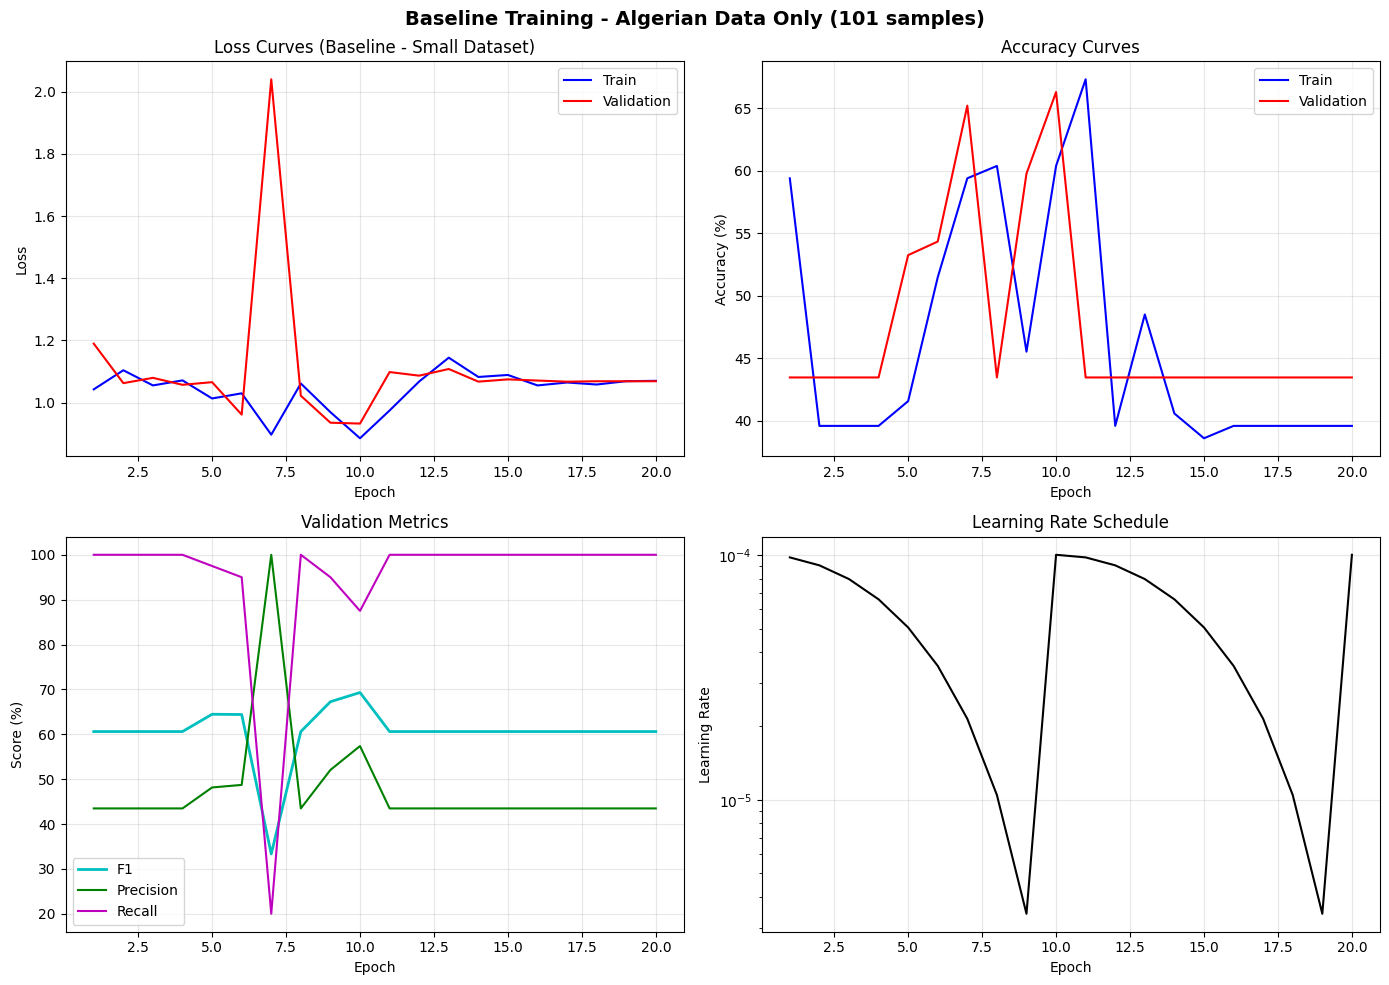

✓ Baseline training history saved


In [11]:
# =============================================================================
# CELL 11: Plot Training History
# =============================================================================

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train')
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Curves (Baseline - Small Dataset)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(epochs, [a*100 for a in history['train_acc']], 'b-', label='Train')
    axes[0, 1].plot(epochs, [a*100 for a in history['val_acc']], 'r-', label='Validation')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Accuracy Curves')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 and Precision/Recall
    axes[1, 0].plot(epochs, [f*100 for f in history['val_f1']], 'c-', label='F1', linewidth=2)
    axes[1, 0].plot(epochs, [p*100 for p in history['val_precision']], 'g-', label='Precision')
    axes[1, 0].plot(epochs, [r*100 for r in history['val_recall']], 'm-', label='Recall')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score (%)')
    axes[1, 0].set_title('Validation Metrics')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 1].plot(epochs, history['lr'], 'k-')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Baseline Training - Algerian Data Only (101 samples)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/home/crop/Desktop/crop2/output/baseline_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Baseline training history saved")

# Plot results
plot_training_history(history)

In [12]:
# =============================================================================
# CELL 12: Final Evaluation
# =============================================================================

def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            preds = (probs > 0.5).astype(float)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    tp = ((all_preds == 1) & (all_labels == 1)).sum()
    fp = ((all_preds == 1) & (all_labels == 0)).sum()
    fn = ((all_preds == 0) & (all_labels == 1)).sum()
    tn = ((all_preds == 0) & (all_labels == 0)).sum()
    
    accuracy = (all_preds == all_labels).mean()
    precision = tp / max(tp + fp, 1)
    recall = tp / max(tp + fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion': (tp, fp, fn, tn),
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

# Evaluate
print("Final Baseline Evaluation")
print("=" * 60)

results = evaluate_model(model, val_loader, device)

print(f"Accuracy:  {results['accuracy']*100:.1f}%")
print(f"Precision: {results['precision']*100:.1f}%")
print(f"Recall:    {results['recall']*100:.1f}%")
print(f"F1 Score:  {results['f1']*100:.1f}%")

tp, fp, fn, tn = results['confusion']
print(f"\nConfusion Matrix:")
print(f"                  Predicted")
print(f"                  Non-Cereal  Cereal")
print(f"Actual Non-Cereal    {tn:4d}      {fp:4d}")
print(f"Actual Cereal        {fn:4d}      {tp:4d}")

print(f"\n⚠️  BASELINE PERFORMANCE:")
print(f"   Training samples: {len(train_dataset)}")
print(f"   This shows the challenge of training on very limited data")
print(f"   Compare with Approach 1 (FDA + hybrid training)")

Final Baseline Evaluation
Accuracy:  43.5%
Precision: 43.5%
Recall:    100.0%
F1 Score:  60.6%

Confusion Matrix:
                  Predicted
                  Non-Cereal  Cereal
Actual Non-Cereal       0        52
Actual Cereal           0        40

⚠️  BASELINE PERFORMANCE:
   Training samples: 101
   This shows the challenge of training on very limited data
   Compare with Approach 1 (FDA + hybrid training)


In [13]:
# =============================================================================
# CELL 13: Save Baseline Model
# =============================================================================

checkpoint_path = Path('/home/crop/Desktop/crop2/output/baseline_cereal_classifier.pth')

checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'history': history,
    'best_f1': best_f1,
    'results': {
        'accuracy': results['accuracy'],
        'precision': results['precision'],
        'recall': results['recall'],
        'f1': results['f1'],
        'confusion': results['confusion']
    },
    'approach': 'baseline_no_fda'
}

torch.save(checkpoint, checkpoint_path)
print(f"✓ Baseline model saved to: {checkpoint_path}")
print(f"  File size: {checkpoint_path.stat().st_size / 1e6:.1f} MB")
print(f"  Approach: Algerian data only (no FDA)")

✓ Baseline model saved to: /home/crop/Desktop/crop2/output/baseline_cereal_classifier.pth
  File size: 110.2 MB
  Approach: Algerian data only (no FDA)


---

## Summary - Approach 2: Baseline (No FDA)

### What We Tested:
- **Training**: Only 101 Algerian samples
- **Validation**: 92 Algerian samples  
- **No domain adaptation**: Pure baseline approach

### Key Findings:
- **Challenge**: Very limited training data leads to high variance
- **Overfitting risk**: Small dataset + complex model
- **Baseline performance**: Shows minimum achievable performance

### Comparison with Approach 1:
- Approach 1 uses FDA-adapted PASTIS (2,433 samples) + Algerian data
- This approach uses only 101 Algerian samples
- Expect significantly lower performance due to data scarcity

### Files Created:
- `output/baseline_cereal_classifier.pth` - Baseline model
- `output/baseline_training_history.png` - Training curves